# Run Mantel tests

Specify input distances and output file:

In [1]:
# input files
phylodist_file <- "../results/clade_founder_tree/clade_founders.mldist"
ratesdist_file <- "../results/synonymous_mut_rates/clade_rate_distances.csv"

outdir <- "../results/mantel_test"
dir.create(outdir,showWarnings = F)

Load packages and set seed:

In [2]:
require(vegan) # for mantel test 
require(dplyr)
require(tidyverse)
require(ggplot2)
require(scales)
require(broom) # for tidying distance matrix

Loading required package: vegan

Loading required package: permute

Loading required package: lattice

This is vegan 2.6-4

Loading required package: dplyr


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Loading required package: tidyverse

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.2 ──
✔ ggplot2 3.3.6     ✔ purrr   0.3.5
✔ tibble  3.1.8     ✔ stringr 1.4.1
✔ tidyr   1.2.1     ✔ forcats 0.5.2
✔ readr   2.1.3     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
Loading required package: scales


Attaching package: ‘scales’


The following object is masked from ‘package:purrr’:

    discard


The following object is masked from ‘package:readr’:

    col_factor


Loading required package: broom



Read data and setup for tests:

In [3]:
# read phylogenetic distances, skipping row 1 (empty) and setting row names equal to column 1 
phylodist <- read.table(phylodist_file, header=F, skip=1, row.names=1)
# make column names the same as row names:
colnames(phylodist) <- rownames(phylodist)

phylodist %>% head

,19A,20A,20B,20C,20E,20F,20G,20I,20J,21C,21F,21I,21J,21K,21L,21M,22A,22B,22C
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
19A,0.0000000,0.0033457,0.0058777,0.0050244,0.0092636,0.0109727,0.0109254,0.0239515,0.0283493,0.0109521,0.0117743,0.0238373,0.0273368,0.0470390,0.0579933,0.0345346,0.0607922,0.0560684,0.0616901
20A,0.0033457,0.0000000,0.0025145,0.0016718,0.0058833,0.0075823,0.0075497,0.0204919,0.0248660,0.0075680,0.0083946,0.0203945,0.0238748,0.0434736,0.0543775,0.0310229,0.0571619,0.0524663,0.0580577
20B,0.0058777,0.0025145,0.0000000,0.0041957,0.0084388,0.0050344,0.0101057,0.0178594,0.0222052,0.0101305,0.0109558,0.0221850,0.0256857,0.0407007,0.0515365,0.0283239,0.0543020,0.0496422,0.0551940
20C,0.0050244,0.0016718,0.0041957,0.0000000,0.0075743,0.0092784,0.0058642,0.0222263,0.0266137,0.0058785,0.0067078,0.0221205,0.0256116,0.0452683,0.0562009,0.0327865,0.0589934,0.0542821,0.0598906
20E,0.0092636,0.0058833,0.0084388,0.0075743,0.0000000,0.0135710,0.0135121,0.0266479,0.0310795,0.0135454,0.0143670,0.0247928,0.0300467,0.0499002,0.0609324,0.0373088,0.0637524,0.0589897,0.0646552
20F,0.0109727,0.0075823,0.0050344,0.0092784,0.0135710,0.0000000,0.0152358,0.0230798,0.0274708,0.0152735,0.0160940,0.0274454,0.0309832,0.0443179,0.0552226,0.0318667,0.0580075,0.0533101,0.0589029


In [4]:
# read rates distances
ratesdist <- read.table(ratesdist_file, sep=",", header=T)

ratesdist %>% head

,rate_type,clade_1,clade_2,mut_rate_distance,is_Omicron
,<chr>,<chr>,<chr>,<dbl>,<chr>
1,rates,20A,20B,0.118520,not Omicron
2,no_GtoT_rates,20A,20B,0.102750,not Omicron
3,clr_rates,20A,20B,0.452740,not Omicron
4,rates,20A,20C,0.106670,not Omicron
5,no_GtoT_rates,20A,20C,0.061564,not Omicron
6,clr_rates,20A,20C,1.009400,not Omicron


Do analysis for each rate type:

'nperm' >= set of all permutations: complete enumeration.

Set of permutations < 'minperm'. Generating entire set.



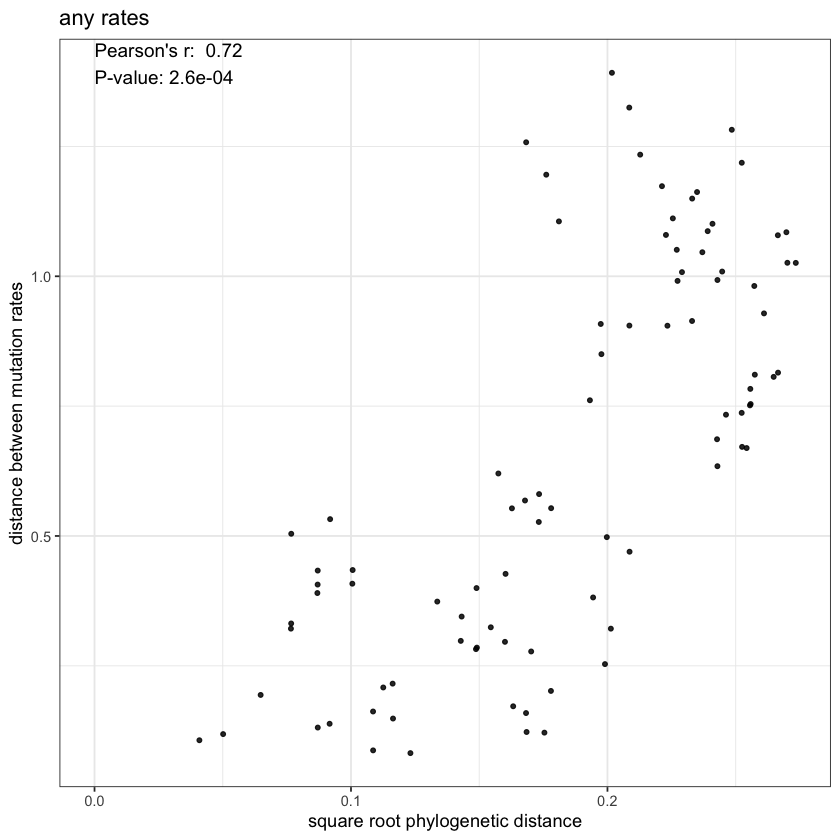

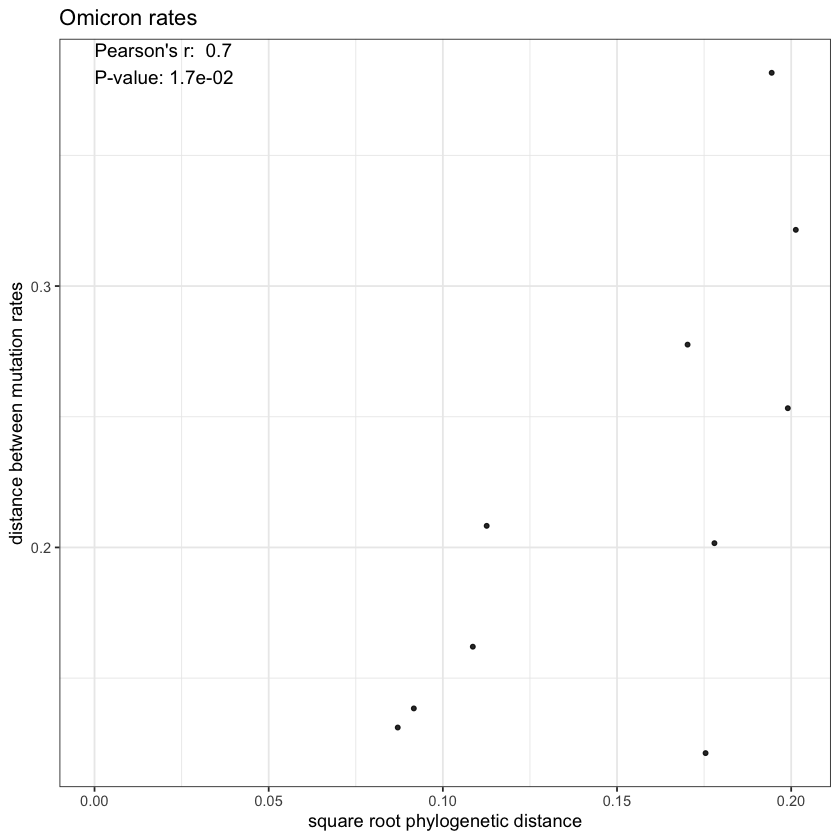

'nperm' >= set of all permutations: complete enumeration.

Set of permutations < 'minperm'. Generating entire set.



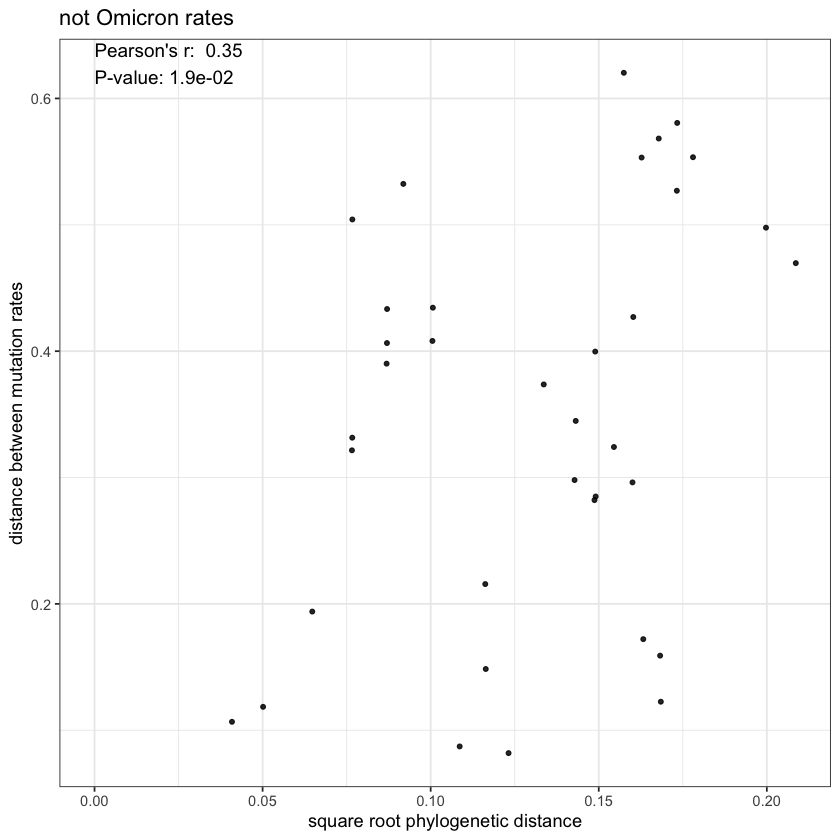

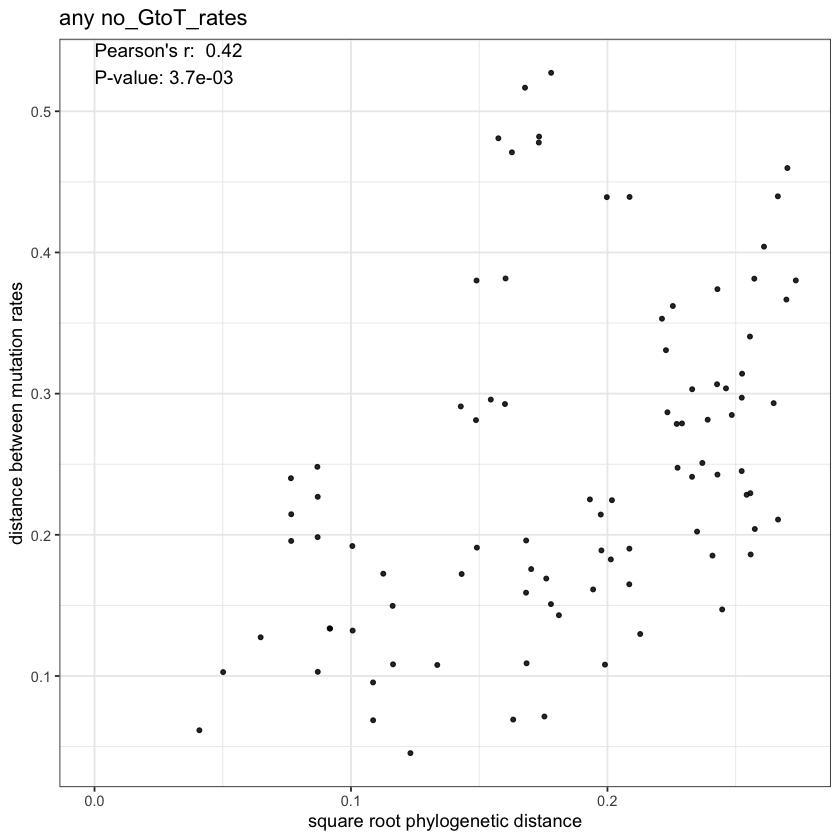

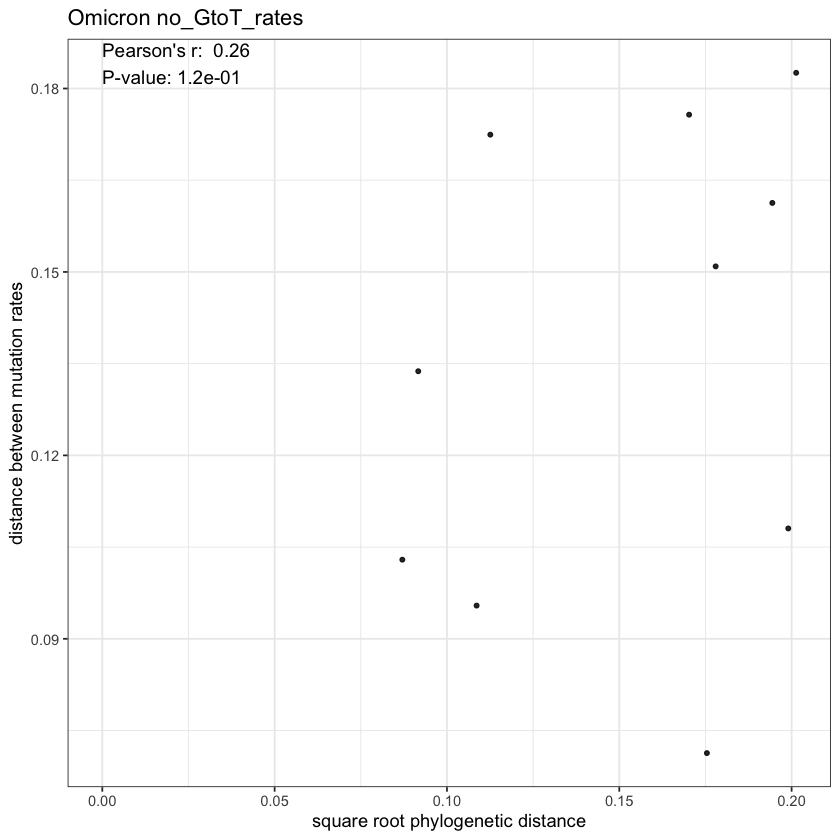

'nperm' >= set of all permutations: complete enumeration.

Set of permutations < 'minperm'. Generating entire set.



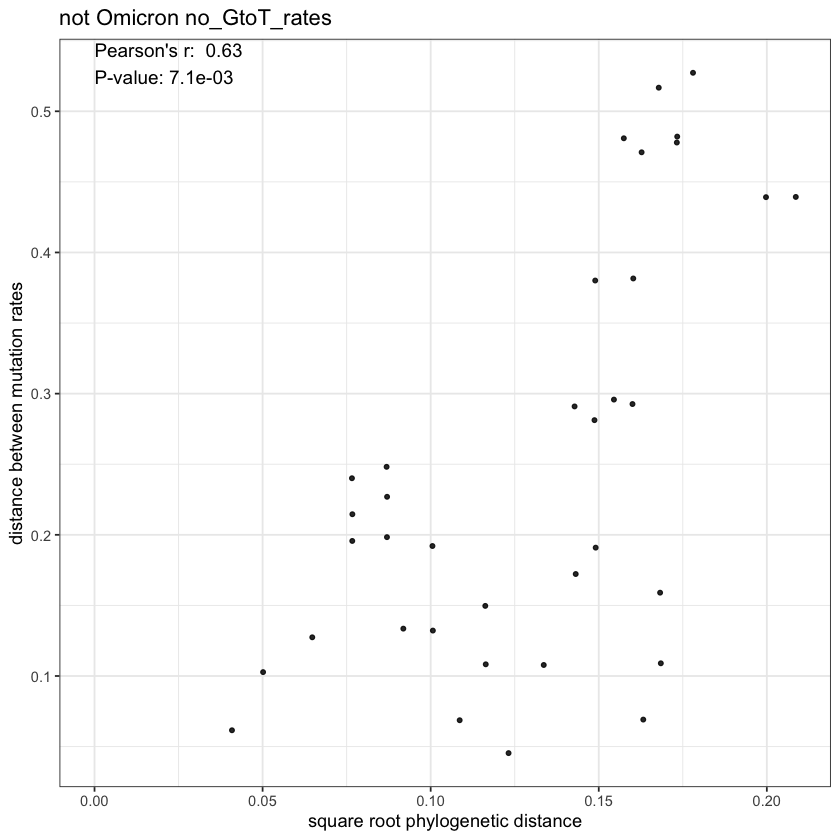

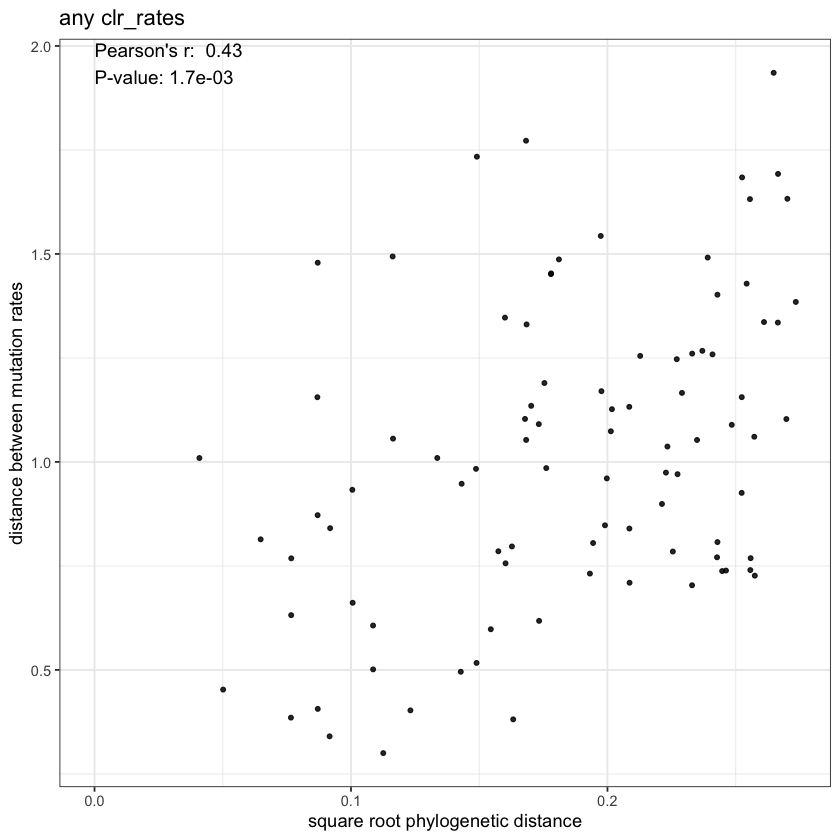

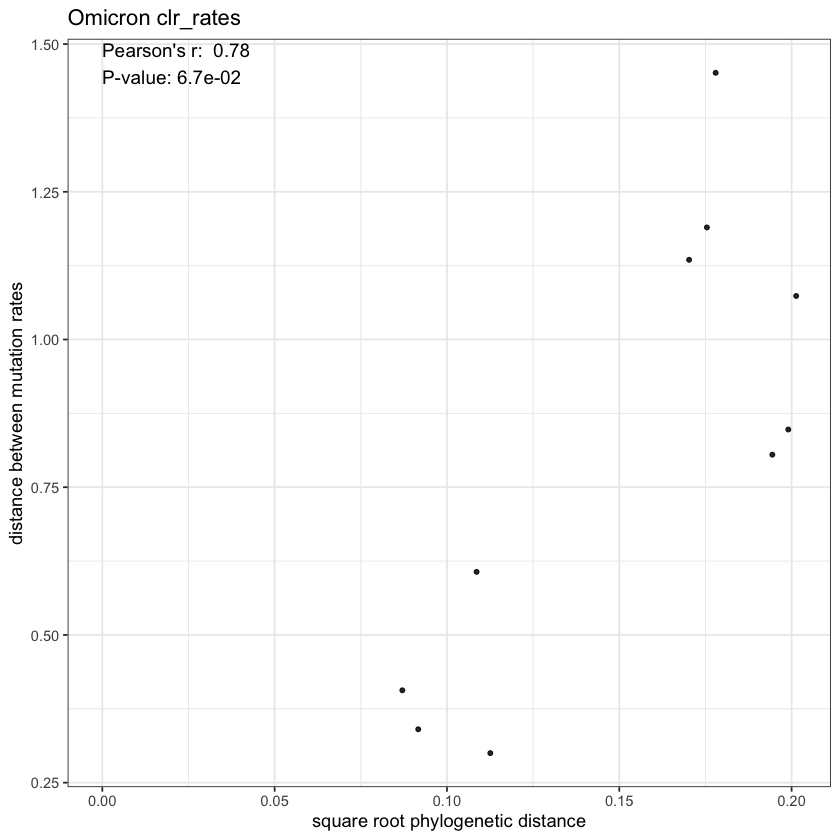

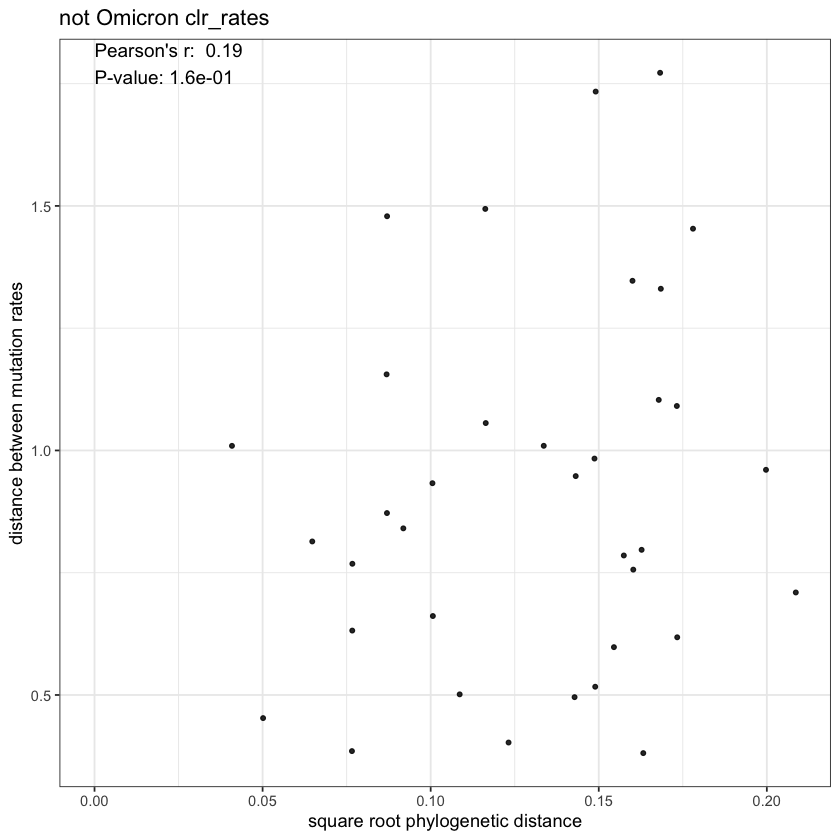

In [5]:
rate_types = ratesdist$rate_type %>% unique

for (ratetype in rate_types) {
for (is_omicron in c("any", "Omicron", "not Omicron")) {

    # select just rates of interest and add diagonal
    ratesdist_type <- ratesdist %>% 
        filter(rate_type==ratetype) %>%
        select(!rate_type)
    
    if (is_omicron != "any") {
        ratesdist_type <- ratesdist_type %>% filter(is_Omicron==is_omicron | clade_1 == clade_2)
    }

    clades <- c(ratesdist_type$clade_1, ratesdist_type$clade_2) %>% unique
    
    # self-self comparisons for diagonal
    self_distances_diagonal <- data.frame(
        clade_1=clades,
        clade_2=clades,
        mut_rate_distance=0,
        is_Omicron=is_omicron
    )
    
    ratesdist_type <- bind_rows(ratesdist_type, self_distances_diagonal)
    
    # pivot wider
    ratesdist_matrix <- ratesdist_type %>%
        select(!is_Omicron) %>%
        pivot_wider(names_from=clade_2, values_from=mut_rate_distance) %>%
        column_to_rownames('clade_1') %>%
        as.matrix()

    # reorder columns to match order of rownames
    ratesdist_matrix <- ratesdist_matrix[,rownames(ratesdist_matrix)]

    # this works to fill in the matrix (note both are lower.tri )
    ratesdist_matrix[lower.tri(ratesdist_matrix)] <- t(ratesdist_matrix)[lower.tri(ratesdist_matrix)]
    
    # order the two matrices in the same way
    # also removes clades from the phylo matrix that aren't in spectrum distance matrix
    # finally, take square root of phylogenetic distances
    phylodist_reordered_subset <- sqrt(phylodist[rownames(ratesdist_matrix), colnames(ratesdist_matrix)])
    
    # make sure row/col names are the same 
    if(sum(rownames(phylodist_reordered_subset) != rownames(ratesdist_matrix)) != 0){
        stop("something is wrong with your matrix setup")
    }

    if(sum(colnames(phylodist_reordered_subset) != colnames(ratesdist_matrix)) != 0){
        stop("something is wrong with your matrix setup")
    }
    
    # run the mantel test on square root of phylogenetic distances
    set.seed(1)
    mantelTestResults <- vegan::mantel(
        phylodist_reordered_subset,
        ratesdist_matrix,
        permutations=100000
    ) # default method = pearson
    
    # data frame of results
    mantelTestResult_df <- data.frame(
        method=as.character(mantelTestResults$method),
        statistic=as.numeric(mantelTestResults$statistic),
        permCount=as.numeric(mantelTestResults$permutations),
        signif=as.numeric(mantelTestResults$signif)
    )
    
    # merge distances for plotting
    phylodist_reordered_subset_table <- tidy(as.dist(phylodist_reordered_subset)) # turn into a table

    # this got rid of self-self distances and duplicates
    colnames(phylodist_reordered_subset_table) <- c("clade_1","clade_2","phylogenetic_distance")

    # combine:
    merged_distances <- merge(
        ratesdist_type,
        phylodist_reordered_subset_table,
        by=c("clade_1","clade_2")
    )
    
    # add labels:
    merged_distances$comparison_label <- paste0(merged_distances$clade_1,"x",merged_distances$clade_2)
    
    # plot results
    plot <- ggplot(merged_distances, aes(x=phylogenetic_distance, y=mut_rate_distance)) +
        geom_point(size=1,alpha=0.85) +
        geom_text(
            data=mantelTestResult_df,
            aes(
                x=0,
                hjust="left",
                y=Inf,
                vjust=1.1,
                label=paste0(
                    "Pearson's r:  ", signif(statistic,2),
                    "\nP-value: ", as.character(scientific(signif,2))
                )
            ),
            size=4
        ) +
      ggtitle(paste0(is_omicron, " ", ratetype)) +
      theme_bw() +
      xlab("square root phylogenetic distance") +
      ylab("distance between mutation rates")
    
    show(plot)
    
}}